In [1]:
import os

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from pandas.plotting import autocorrelation_plot
import statsmodels.tsa.api as smt

plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
data_path = "../downloads/demand-forecasting-kernels-only/train.csv"
df = pd.read_csv(data_path)

In [3]:
df = df.set_index('Page') 

KeyError: "None of ['Page'] are in the columns"

In [ ]:
df.head()

In [6]:
df.date = pd.to_datetime(df.date)

In [7]:
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['weeknum'] = df.date.dt.weekofyear

In [8]:
df.head()

,date,store,item,sales,year,month,weeknum
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,1
2,2013-01-03,1,1,14,2013,1,1
3,2013-01-04,1,1,13,2013,1,1
4,2013-01-05,1,1,10,2013,1,1


In [10]:
first_item = df.query('item == 1')
pivot = first_item.pivot(index='date', columns='store', values='sales')

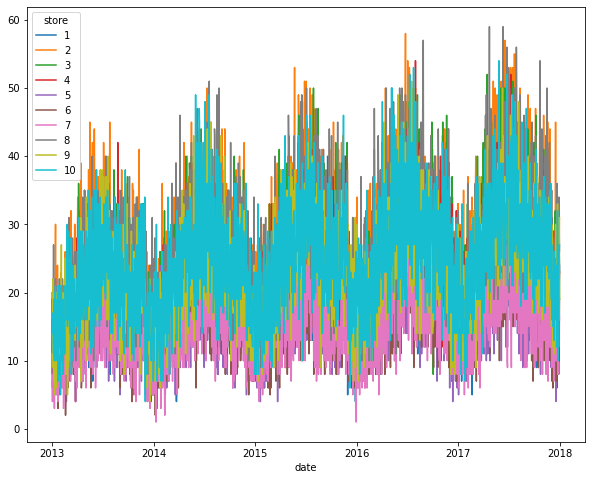

In [11]:

sns.lineplot(data=pivot, dashes=False)

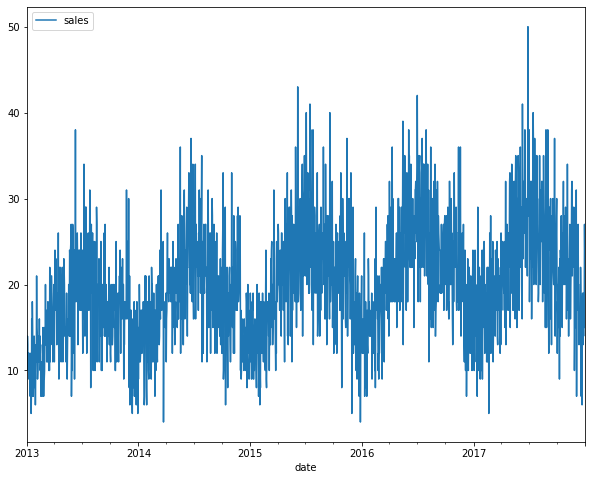

In [12]:
first_store = first_item.query('store==1')
first_store.plot(x='date', y='sales')

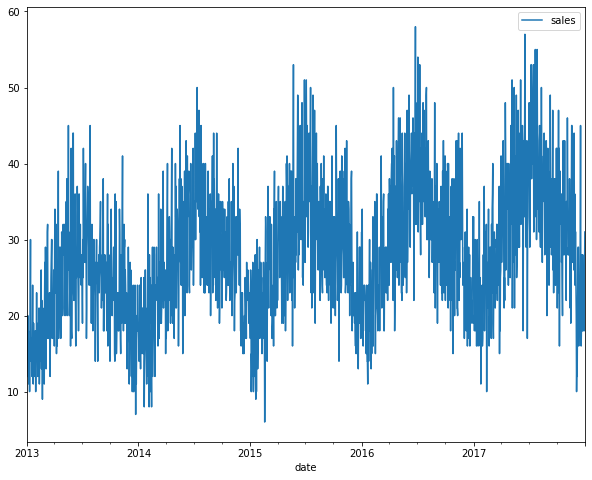

In [13]:
first_item.query('store==2').plot(x='date', y='sales')

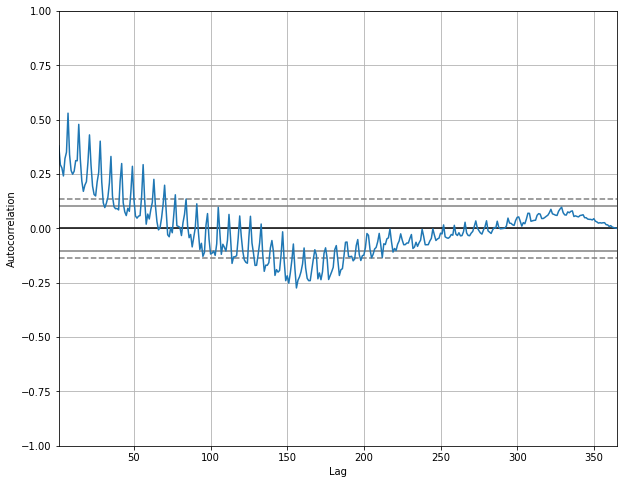

In [14]:
autocorrelation_plot(first_item.query('store==1 and year == 2015').sales)

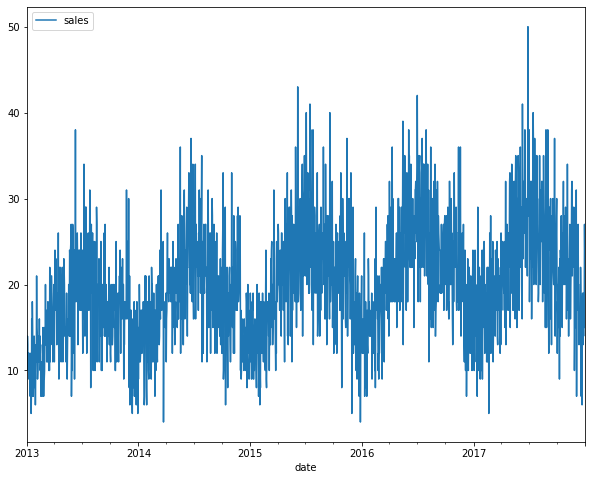

In [15]:
first_store = first_item.query('store==1')
first_store.plot(x='date', y='sales')

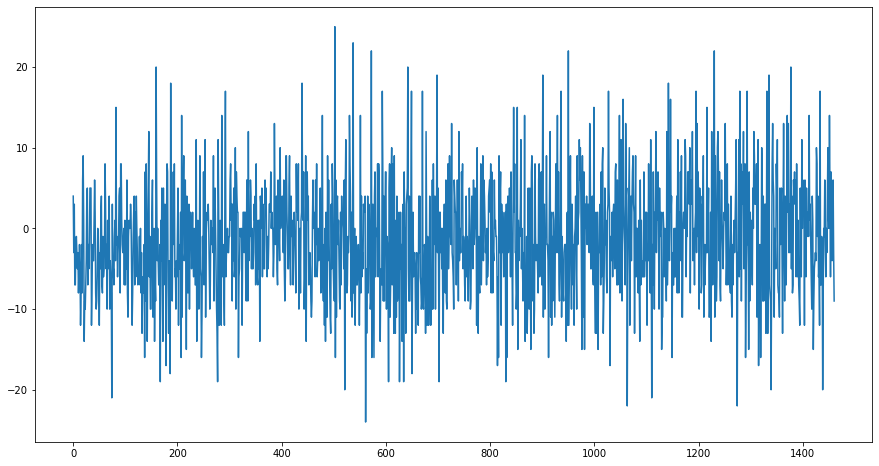

In [16]:
fig, ax =  plt.subplots(1,1, figsize=(15,8))
lag = 365
diff = (first_store.sales.iloc[:-lag].values - first_store.sales.iloc[lag:].values)
sns.lineplot(data=diff, ax=ax)

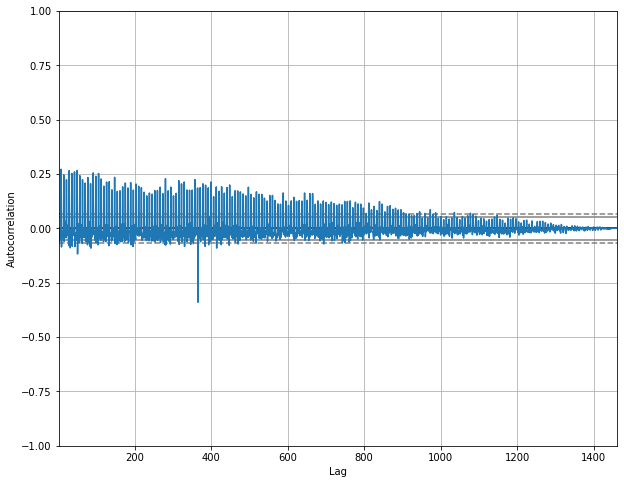

In [17]:
autocorrelation_plot(diff)

In [18]:
first_store['rolling_mean_30'] = first_store.sales.rolling(30).mean()
first_store['rolling_mean_90'] = first_store.sales.rolling(90).mean()
first_store['rolling_mean_182'] = first_store.sales.rolling(182).mean()

/Users/jesterilianight/miniconda3/envs/ml_tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jesterilianight/miniconda3/envs/ml_tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jesterilianight/miniconda3/envs/ml_tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set 

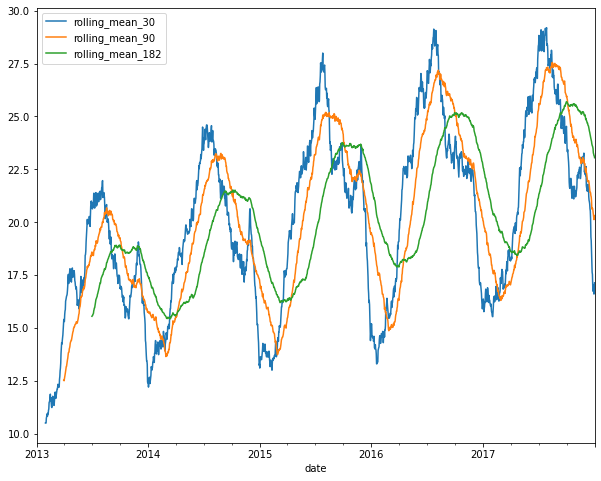

In [19]:
# first_store.plot(x='date', y=['rolling_mean_32', 'rolling_mean_7', 'rolling_mean_14'])
first_store.plot(x='date', y=['rolling_mean_30', 'rolling_mean_90', 'rolling_mean_182'])
# first_store.plot(x='date', y=)

In [20]:
first_item['sales_rolling_30'] = first_item.groupby('store')['sales'].rolling(30).mean().reset_index()['sales']
first_item['sales_rolling_90'] = first_item.groupby('store')['sales'].rolling(90).mean().reset_index()['sales']

/Users/jesterilianight/miniconda3/envs/ml_tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jesterilianight/miniconda3/envs/ml_tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


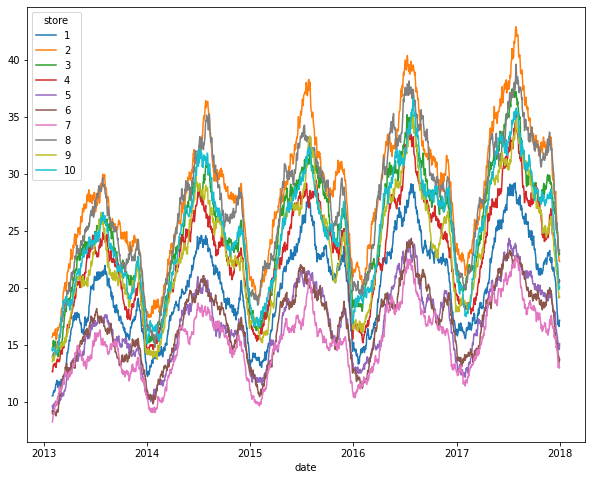

In [21]:
pivot = first_item.pivot(index='date', columns='store', values='sales_rolling_30')
sns.lineplot(data=pivot, dashes=False)

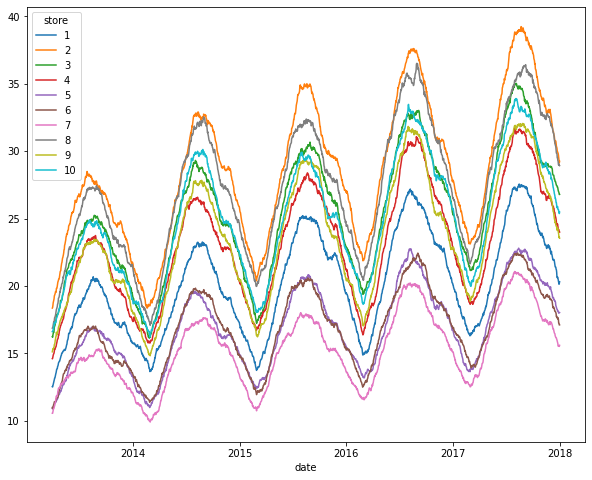

In [22]:
pivot = first_item.pivot(index='date', columns='store', values='sales_rolling_90')
sns.lineplot(data=pivot, dashes=False)

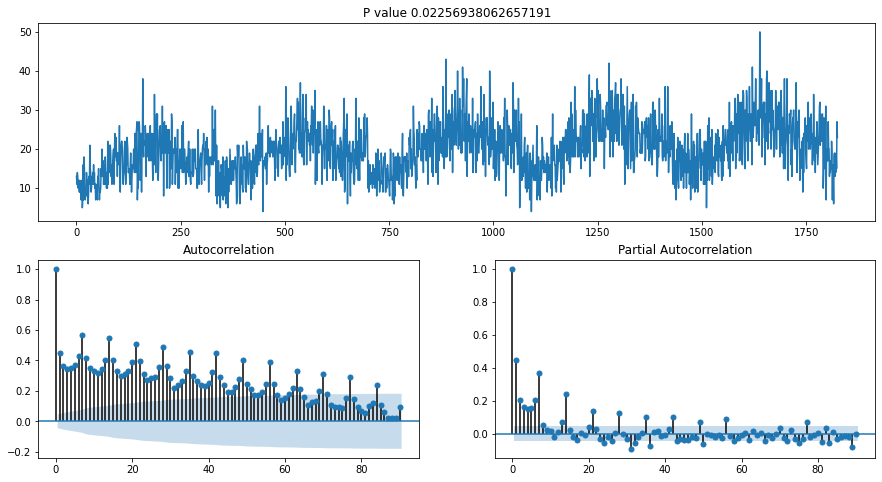

In [23]:
first_item_first_store = first_item.query('store==1')
p_value = smt.stattools.adfuller(first_item_first_store.sales)[1]

lag = 90
plt.figure(figsize=(15,8))
ax = plt.subplot2grid((2,2), (0,0), colspan=2)
ax.plot(first_item_first_store.sales)
ax.set_title(f"P value {p_value}")
ax = plt.subplot2grid((2,2), (1,0))
smt.graphics.plot_acf(first_item_first_store.sales.dropna(), ax=ax, lags=lag);
ax = plt.subplot2grid((2,2), (1,1))
smt.graphics.plot_pacf(first_item_first_store.sales.dropna(), ax=ax, lags=lag);


We can see 7 days seasonality

Let's remove it by taking a difference

### Removing seasonality

In [24]:
season_7_days_diff = first_item_first_store.sales - first_item_first_store.sales.shift(14)
p_value = smt.stattools.adfuller(season_7_days_diff.dropna())[1]

/Users/jesterilianight/miniconda3/envs/ml_tensorflow/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


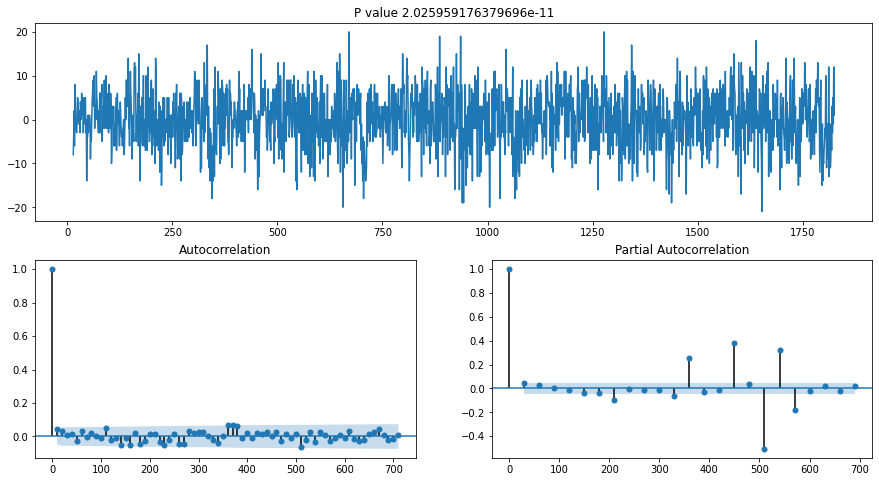

In [25]:
plt.figure(figsize=(15,8))
ax = plt.subplot2grid((2,2), (0,0), colspan=2)
ax.plot(season_7_days_diff)
ax.set_title(f"P value {p_value}")
ax = plt.subplot2grid((2,2), (1,0))
smt.graphics.plot_acf(season_7_days_diff.dropna().values, ax=ax, lags=np.arange(0, 720, 10));
ax = plt.subplot2grid((2,2), (1,1))
smt.graphics.plot_pacf(season_7_days_diff.dropna().values, ax=ax, lags=np.arange(0, 720, 30));

There is also 365 days seasonality

In [26]:
remove_365_seasons = (season_7_days_diff - season_7_days_diff.shift(365)).dropna()

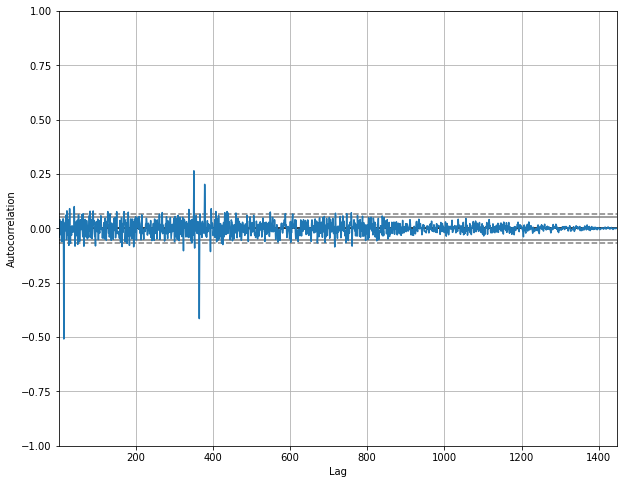

In [27]:
autocorrelation_plot(remove_365_seasons)
# autocorrelation_plot(first_item_first_store.sales_rolling_30.dropna())

/Users/jesterilianight/miniconda3/envs/ml_tensorflow/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


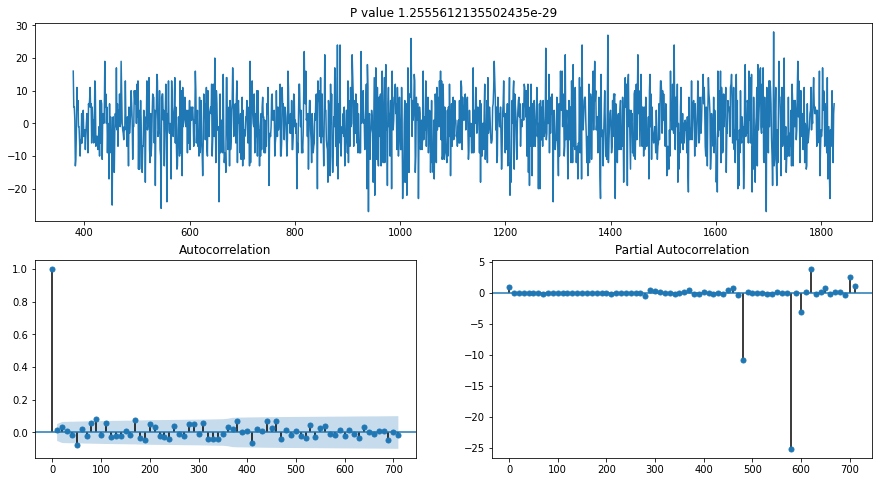

In [28]:
p_value = smt.stattools.adfuller(remove_365_seasons.dropna())[1]
plt.figure(figsize=(15,8))
ax = plt.subplot2grid((2,2), (0,0), colspan=2)
ax.plot(remove_365_seasons)
ax.set_title(f"P value {p_value}")
ax = plt.subplot2grid((2,2), (1,0))
smt.graphics.plot_acf(remove_365_seasons, ax=ax, lags=np.arange(0, 720, 10));
ax = plt.subplot2grid((2,2), (1,1))
smt.graphics.plot_pacf(remove_365_seasons, ax=ax, lags=np.arange(0, 720, 10));

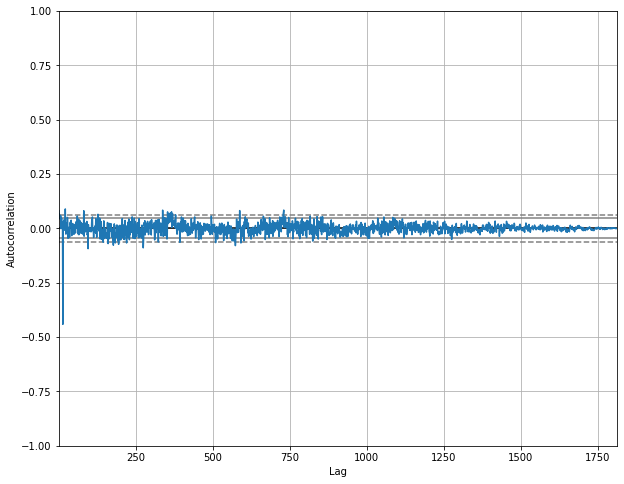

In [29]:
autocorrelation_plot(season_7_days_diff.dropna())

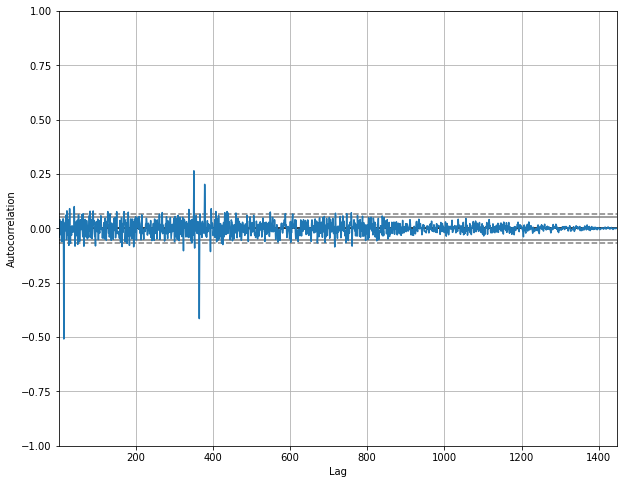

In [30]:
autocorrelation_plot(remove_365_seasons.dropna())

## Check correlations

In [285]:
corr = pivot.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [288]:
df.head()

,date,store,item,sales,year,month,weeknum
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,1
2,2013-01-03,1,1,14,2013,1,1
3,2013-01-04,1,1,13,2013,1,1
4,2013-01-05,1,1,10,2013,1,1


In [289]:
df['item_store'] = df['item'].astype('str')+"_" + df['store'].astype(str)

In [297]:
# pivot = df.pivot(index='date', columns='item_store', values='sales')
pivot = df.query('store==1').pivot(index='date', columns='item', values='sales')

In [298]:
pivot

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,33,15,10,11,31,25,33,18,37,...,6,21,22,20,37,30,17,21,18,30
2013-01-02,11,43,30,11,6,36,23,37,23,34,...,15,24,27,15,40,30,15,26,10,32
2013-01-03,14,23,14,8,8,18,34,38,25,32,...,5,14,19,11,42,30,5,25,17,25
2013-01-04,13,18,10,19,9,19,36,54,22,45,...,9,22,29,22,49,37,13,26,22,32
2013-01-05,10,34,23,12,8,31,38,51,29,35,...,13,18,34,19,52,28,12,28,15,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,14,55,26,16,6,32,45,58,37,55,...,10,23,29,22,65,43,12,31,17,38
2017-12-28,19,50,21,20,15,51,36,49,34,63,...,9,19,28,19,54,41,15,37,21,52
2017-12-29,15,50,38,25,17,55,57,54,46,56,...,22,15,32,36,77,48,21,39,23,59


## STL decomposition

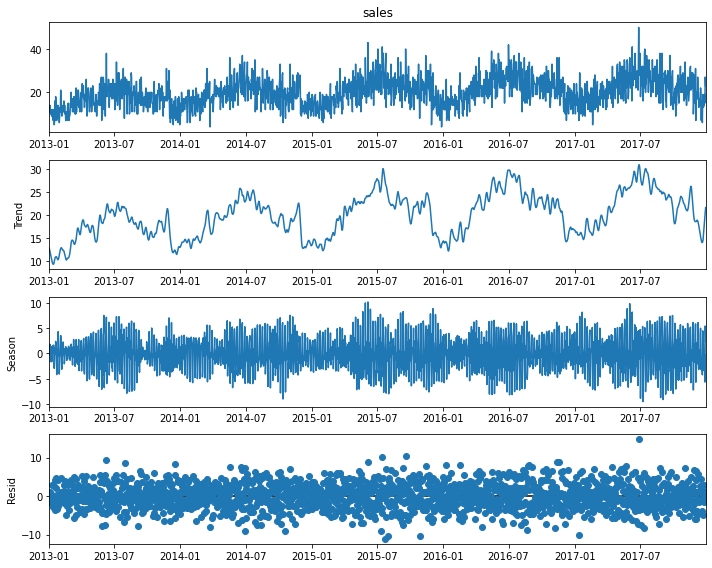

In [36]:
stl = smt.STL(first_item_first_store.set_index('date').sales)
fitted =stl.fit()
fitted.plot();